<a href="https://colab.research.google.com/github/ethvedbitdesjan/ChromeExtensionHighlight/blob/main/Convnext_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('content/')

Mounted at content/


In [2]:
%cd content/MyDrive/SummerResearch

/content/content/MyDrive/SummerResearch


In [3]:
# Critical imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import cv2
import copy
import torch
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler

In [4]:
import shutil

In [5]:
funny_set = set()
not_funny_set = set()
with open('labelled_data/funny_combined1.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        funny_set.add(line.strip())
with open('labelled_data/not_funny_combined1.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        not_funny_set.add(line.strip())
len(funny_set), len(not_funny_set)

(1133, 1560)

In [6]:
%%capture
!pip install datasets
!pip install wandb -qU

In [7]:
%%capture
!pip install weightwatcher

In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
import weightwatcher as ww

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
folders = []
for file in os.scandir('Dataset/train'):
  if file.is_dir():
    folders.append(file.name)
folders

['Funny_Combined', 'Not_Funny_Combined']

In [12]:
class FunnyNotFunnyDataset(Dataset):
    def __init__(self, data=[], root_dir=None, transform=None):
        if root_dir[-1] != '/':
          root_dir += '/'
        self.root_dir = root_dir
        classes = []
        for file in os.scandir(root_dir):
          if file.is_dir():
            classes.append(file.name)
        data = []
        for i, class_name in enumerate(classes):
          for file in os.listdir(root_dir+class_name):
            data.append((root_dir + class_name + '/'+ file, i))
        self.data = data
        self.num_classes = len(classes)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image = Image.open(self.data[index][0])
        if self.transform:
          image = self.transform()(image)
        label = self.data[index][1]
        label_tensor = torch.zeros(1)
        if label == 1:
          label_tensor[0] = 1
        return {'image_data':image, 'label':label_tensor}

In [13]:
class ResNetAdded(torch.nn.Module):
    def __init__(self, resnet50=None, train_full=True):
        super(ResNetAdded, self).__init__()
        if resnet50:
            self.resnet50 = resnet50
        else:
            self.resnet50 = models.resnet50(pretrained=True)
        if not train_full:
            for param in self.resnet50.parameters():
                param.requires_grad = False
        self.resnet50.fc = torch.nn.Linear(2048, 1)
        self.feature_extractor = None

    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """

        # x = self.resnet50(x)
        # preds = self.classifier(x)
        preds = self.resnet50(x)
        return preds

    def feature_extraction(self, x):
        if self.feature_extractor is None:
            self.feature_extractor = torch.nn.Sequential(*(list(self.resnet50.children())[:-1]))
        features = self.feature_extractor(x)
        return features

class AlexNetAdded(torch.nn.Module):
    def __init__(self, alexnet=None, train_full=True):
        super(AlexNetAdded, self).__init__()
        if alexnet:
            self.alexnet = alexnet
        else:
            self.alexnet = models.alexnet(pretrained=True)
        if not train_full:
            for param in self.alexnet.parameters():
                param.requires_grad = False
        self.alexnet.classifier[6] = torch.nn.Linear(4096, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.alexnet(x)
        return preds

class InceptionAdded(torch.nn.Module):
    def __init__(self, inception=None, train_full=True):
        super(InceptionAdded, self).__init__()
        if inception:
            self.xception = inception
        else:
            self.inception = models.inception_v3(pretrained=True)
        if not train_full:
            for param in self.inception.parameters():
                param.requires_grad = False
        self.inception.fc = torch.nn.Linear(2048, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.inception(x)
        return preds

class DenseNetAdded(torch.nn.Module):
    def __init__(self, densenet=None, train_full=True):
        super(DenseNetAdded, self).__init__()
        if densenet:
            self.densenet = densenet
        else:
            self.densenet = models.densenet201(pretrained=True)
        if not train_full:
            for param in self.densenet.parameters():
                param.requires_grad = False
        self.densenet.classifier = torch.nn.Linear(1920, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.densenet(x)
        return preds
class ConvNextAdded(torch.nn.Module):
    def __init__(self, convnext=None, train_full=True, pretrained=True):
        super(ConvNextAdded, self).__init__()
        if convnext:
            self.convnext = convnext
        else:
            self.convnext = models.convnext_base(pretrained=pretrained)
        if pretrained:
          if not train_full:
              for param in self.convnext.parameters():
                  param.requires_grad = False
        self.convnext.classifier[2] = torch.nn.Linear(1024, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.convnext(x)
        return preds

In [14]:
model = ConvNextAdded(train_full=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:04<00:00, 83.1MB/s]


In [15]:
IMAGE_SIZE = 224
NUM_CLASSES = 2
BATCH_SIZE = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
train_transform = models.ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms
test_transform = models.ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms
train_dataset = FunnyNotFunnyDataset(root_dir='Dataset/train', transform = train_transform)
valid_dataset = FunnyNotFunnyDataset(root_dir='Dataset/valid', transform = test_transform)
test_dataset = FunnyNotFunnyDataset(root_dir='Dataset/test' ,transform = test_transform)
train_dataset

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)
model.to(device)

ConvNextAdded(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): L

In [17]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [18]:
import gc
gc.collect()

32

In [19]:
import matplotlib.pyplot as plt

In [20]:
def train(num_epochs, save_name):
  best_valid_loss = 10000
  best_valid_epoch = -1
  all_train_losses = []
  all_valid_losses = []
  count = 0
  for epoch in range(num_epochs):
    print('epoch:', epoch)
    model.train()
    running_loss = 0.0
    total_loss = []
    lrs = []
    total_size = 0
    correct = 0
    for i, data in enumerate(train_dataloader):
      inputs = data['image_data'].to(device)
      label = data['label'].to(device)
      inputs = inputs.type(torch.cuda.FloatTensor)
      label = label.type(torch.cuda.FloatTensor)
      output = model.forward(inputs)
      gc.collect()
      del inputs
      loss = criterion(output, label)
      loss.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
      total_loss.append(loss.item())
      gc.collect()
      del loss
      torch.cuda.empty_cache()
      output = torch.sigmoid(output)
      predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
      correct += (predictions == label).float().sum().item()
      gc.collect()
      #gpu_usage()
      del predictions
      del label
      del output
      #gpu_usage()
      torch.cuda.empty_cache()
      #print(predictions, "\n", targets, "\n", correct)
      total_size += BATCH_SIZE
      accuracy = correct/(total_size)
      #print(correct, total_size)
      lrs.append(optimizer.param_groups[0]['lr'])
    print('Mean Train loss:', np.mean(total_loss), 'Train Accuracy:', accuracy)
    all_train_losses.append(np.mean(total_loss))
    model.eval()
    total_size = 0
    total_loss = []
    correct = 0
    with torch.no_grad():
        for data in valid_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            inputs = data["image_data"].to(device)
            targets = data["label"].to(device)

            inputs = inputs.type(torch.cuda.FloatTensor)
            targets = targets.type(torch.cuda.FloatTensor)
            #print(ids.shape, "ids")
            batch_size = inputs.size(0)

            output = model.forward(inputs)
            gc.collect()
            del inputs
            loss = criterion(output, targets)
            total_loss.append(loss.item())
            gc.collect()
            del loss
            torch.cuda.empty_cache()
            output = torch.sigmoid(output)

            predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
            if (predictions == targets).float().sum().item() > batch_size:
              print('error?')
            correct += (predictions == targets).float().sum().item()
            gc.collect()
            del predictions
            del targets
            del output
            torch.cuda.empty_cache()
            total_size += batch_size
            #gpu_usage()
        accuracy = correct/(total_size)
    all_valid_losses.append(np.mean(total_loss))
    if np.sum(total_loss) < best_valid_loss:
      best_valid_loss = np.sum(total_loss)
      best_model_weights = copy.deepcopy(model.state_dict())
      best_valid_epoch = epoch
      path = save_name
      torch.save(model.state_dict(), path)
      print(f"Model Saved")
    if len(all_valid_losses) > 1:
      if np.abs(all_valid_losses[-1] - all_valid_losses[-2]) > 0.01:
        count = 0
      else:
        count += 1
    print("Validation Loss over a batch: {:.4f}; Validation Accuracy: {:.2f}%".format(np.mean(total_loss), accuracy*100))
    # if count > 2:
    #   break
  epochs = [i+1 for i in range(len(all_train_losses))]
  plt.plot(epochs, all_train_losses, marker='o')
  plt.plot(epochs, all_valid_losses, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
def test():
  model.eval()
  total_size = 0
  total_loss = []
  correct = 0
  all_preds = []
  all_targets = []
  with torch.no_grad():
      for data in test_dataloader:
          gc.collect()
          torch.cuda.empty_cache()
          inputs = data["image_data"].to(device)
          targets = data["label"].to(device)

          inputs = inputs.type(torch.cuda.FloatTensor)
          targets = targets.type(torch.cuda.FloatTensor)
          #print(ids.shape, "ids")
          batch_size = inputs.size(0)

          output = model.forward(inputs)
          gc.collect()
          del inputs
          loss = criterion(output, targets)
          total_loss.append(loss.item())
          gc.collect()
          del loss
          torch.cuda.empty_cache()
          output = torch.sigmoid(output)

          predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
          if (predictions == targets).float().sum().item() > batch_size:
            print('error?')
          all_preds += predictions.flatten().cpu().detach().tolist()
          all_targets += targets.flatten().cpu().detach().tolist()
          correct += (predictions == targets).float().sum().item()
          gc.collect()
          del predictions
          del targets
          del output
          torch.cuda.empty_cache()
          total_size += batch_size
          #gpu_usage()
      accuracy = correct/(total_size)
  print("Total Test Loss: {:.4f}; Test Accuracy: {:.2f}%".format(np.sum(total_loss), accuracy*100))
  print(pd.DataFrame(confusion_matrix(all_preds, all_targets), columns=['Test Funny', 'Test Not Funny'], index=['Pred Funny', 'Pred Not Funny']))

epoch: 0
Mean Train loss: 0.6700390099298836 Train Accuracy: 0.5971534653465347
Model Saved
Validation Loss over a batch: 0.6550; Validation Accuracy: 59.93%
epoch: 1
Mean Train loss: 0.6103360883080133 Train Accuracy: 0.682549504950495
Model Saved
Validation Loss over a batch: 0.6396; Validation Accuracy: 60.67%
epoch: 2
Mean Train loss: 0.5837527026634405 Train Accuracy: 0.7153465346534653
Model Saved
Validation Loss over a batch: 0.6379; Validation Accuracy: 62.52%
epoch: 3
Mean Train loss: 0.5700939610452935 Train Accuracy: 0.6998762376237624
Model Saved
Validation Loss over a batch: 0.6378; Validation Accuracy: 61.04%
epoch: 4
Mean Train loss: 0.5480503115323511 Train Accuracy: 0.7308168316831684
Validation Loss over a batch: 0.6386; Validation Accuracy: 62.52%
epoch: 5
Mean Train loss: 0.5387317815629562 Train Accuracy: 0.7357673267326733
Validation Loss over a batch: 0.6403; Validation Accuracy: 62.15%
epoch: 6
Mean Train loss: 0.5343226583877413 Train Accuracy: 0.72896039603960

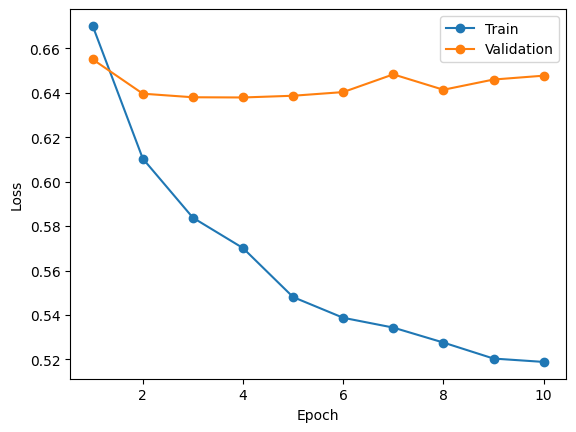

In [23]:
train(num_epochs=10, save_name="best_model_convnext_last_layer.bin")

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('best_model_convnext_last_layer.bin'))
model.to(device)

ConvNextAdded(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): L

In [25]:
test()

Total Test Loss: 21.7076; Test Accuracy: 63.64%
                Test Funny  Test Not Funny
Pred Funny             109              80
Pred Not Funny         116             234
